## Adversarial Attacks on Pre-trained Keras/Tensorflow Models
This notebook demonstrates how networks with very large numbers of inputs (in this case, 128x128x3 pixels), can be attacked through undetectable modifications to an input image.  We use Tensorflow's auto-differentiation capabilities to make minimal tiny modifications to each pixel which cumulatively result in huge shifts in output probabilities.

-----

**NOTE: The example data and pretrained model have been copied from the "Dogs vs. Cats" Kaggle competition page:**

  * Competition Page: https://www.kaggle.com/c/dogs-vs-cats
  * Solution Notebook: https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification
  
All credit to goes to Kaggle and the user "uysimty" for this base material.  The purpose of this notebook is not to identify deficiencies in the technical work done by "uysimty" but instead identify a deficiency and general neural-network architectures.

-----

### Import Relevant Libraries

In [ ]:
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Download the pre-trained model

In [ ]:
import requests

if os.path.exists('./model.h5'):
    print('Model already exists locally, no need to download again')
else:
    # Pre-trained model weights are stored in my S3 bucket
    model_url = 'https://areiner-toptal-blog-resources.s3.amazonaws.com/dogs_and_cats/model.h5'
    with open('model.h5', 'wb') as f:
        f.write(requests.get(model_url).content)


    print(f'Finished downloading model weights to "model.h5"')


file_size_mb = os.stat('model.h5').st_size / (1024 * 1024.)
print(f'Model weights file is {file_size_mb:.1f}MB')

# Define Constants

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMG_SIZE_2D = (IMG_WIDTH, IMG_HEIGHT)
IMG_SIZE_3D = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

## Model Achitecture
Here's the model architecture as shown from the Kaggle page:

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

## Recreate the Model Architecture, Load the Weights
The downloaded file is just the weights, without any architecture information.  Need to 

In [ ]:
from tensorflow.keras import layers as L

x = inputs = L.Input(shape=IMG_SIZE_3D)
x = L.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE_3D)(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Dropout(0.25)(x)

x = L.Conv2D(64, (3, 3), activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Dropout(0.25)(x)

x = L.Conv2D(128, (3, 3), activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Dropout(0.25)(x)

x = L.Flatten()(x)
x = L.Dense(512, activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.5)(x)

# Orig model used softmax, but can be changed to sigmoid without affecting
# classification results, and sigmoid will be better for our manipulations
x = outputs = L.Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

In [4]:
model.load_weights('model.h5')

Found 12500 images in dir: ./test1
Example images:


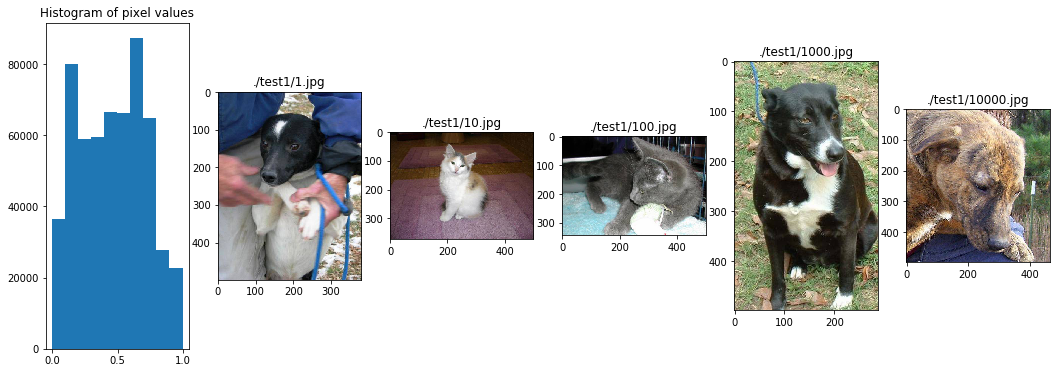

In [5]:
test_dir = './test1'
test_img_paths = sorted([f for f in os.listdir(test_dir) if not f.startswith('.')])
print(f'Found {len(test_img_paths)} images in dir: {test_dir}')
print(f'Example images:')

sample_imgs = {}
fig, axs = plt.subplots(1,6, figsize=(18,6))
for i in range(5):
    img_path = os.path.join(test_dir, test_img_paths[i])
    img = img_to_array(load_img(img_path), data_format='channels_last') / 256.
    if i == 0:
        axs[i].hist(img.reshape([-1]))
        axs[i].set_title('Histogram of pixel values')
    sample_imgs[img_path] = img
    axs[i+1].imshow(img)
    axs[i+1].set_title(img_path)

In [6]:
# This method reverses the last sigmoid activation
inverse_sigmoid = lambda y : -tf.math.log(1. / y - 1.)

def get_model_output(model, img3d):
    # Add batch dimension to predict with model, then remove extra dim in result
    return tf.squeeze(model.predict(tf.expand_dims(img3d, axis=0)))

def get_eval_str(model, img3d):
    # Add batch dimension to predict with model, then remove extra dim in result
    model_output = get_model_output(model, img3d)
    
    # Model outputs passed through sigmoid, but want softmax for display
    probas = tf.nn.softmax(inverse_sigmoid(model_output)).numpy()
    
    if probas[0] > probas[1]:
        pred_str, conf = 'CAT', f'{100*probas[0]:.1f}'
    else:
        pred_str, conf = 'DOG', f'{100*probas[1]:.1f}'
        
        
    line_1 = r'Predicted: $\bf{' + pred_str + '}$'
    line_2 = r'Confidence: $\bf{' + conf + '}$%'
    return line_1 + '\n' + line_2

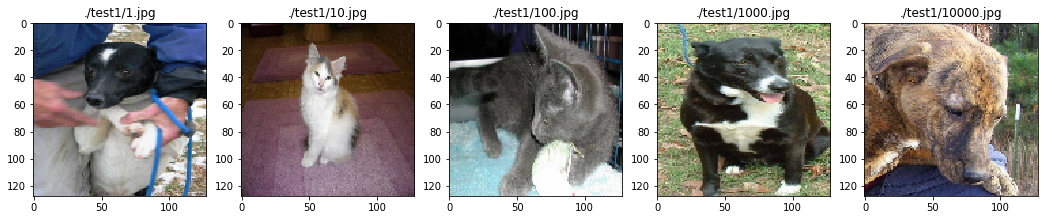

In [7]:
resz_imgs = dict([(fn, tf.image.resize(img, size=IMAGE_SIZE)) for fn,img in sample_imgs.items()])

fig, axs = plt.subplots(1,5,figsize=(18,6))
i = 0
for fn,img in resz_imgs.items():
    axs[i].imshow(img)
    axs[i].set_title(fn)
    i += 1

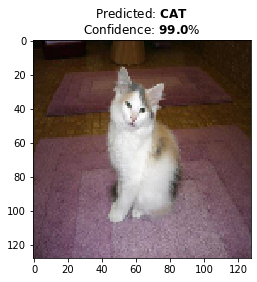

In [8]:
victim_img = resz_imgs['./test1/10.jpg']
predict_str = get_eval_str(model, victim_img)
plt.imshow(victim_img)
_ = plt.title(predict_str)

In [22]:

def adversarial_modify(victim_img, to_dog):
    orig_victim_img = victim_img[:, :, :]
    grad_dir = 1 if to_dog else -1
    
    fig, axs = plt.subplots(1,4, figsize=(18,8))
    axs[0].imshow(victim_img)
    axs[0].set_title(get_eval_str(model, victim_img))
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    for i in range(3):

        # Auto-grad can only track tensors
        tf_victim_img = tf.convert_to_tensor(victim_img, dtype='float32')

        with tf.GradientTape() as tape:
            tape.watch(tf_victim_img)

            # Run the image through the model
            model_output = tf.squeeze(model(tf.expand_dims(tf_victim_img, axis=0)))

            # This is a picture of cat, let's try to make it evaluate as a dog
            loss = grad_dir * (model_output[0] - model_output[1])

        dloss_dimg = tape.gradient(loss, tf_victim_img)

        # Create masks to add exactly +1 pixel count to everything with positive grad, -1 for negative grad
        pixels_w_pos_grad = tf.cast(dloss_dimg > 0.0, 'float32') / 255.
        pixels_w_neg_grad = tf.cast(dloss_dimg < 0.0, 'float32') / 255.

        victim_img = tf.clip_by_value(victim_img - pixels_w_pos_grad + pixels_w_neg_grad, 0.0, 1.0)

        axs[i+1].imshow(victim_img)
        axs[i+1].set_title(f'{get_eval_str(model, victim_img)}')
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])
        
    return victim_img

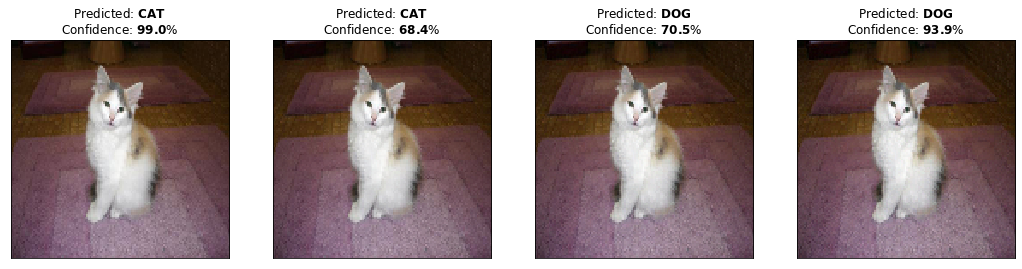

In [27]:
adv_img = adversarial_modify(resz_imgs['./test1/10.jpg'], to_dog=True)

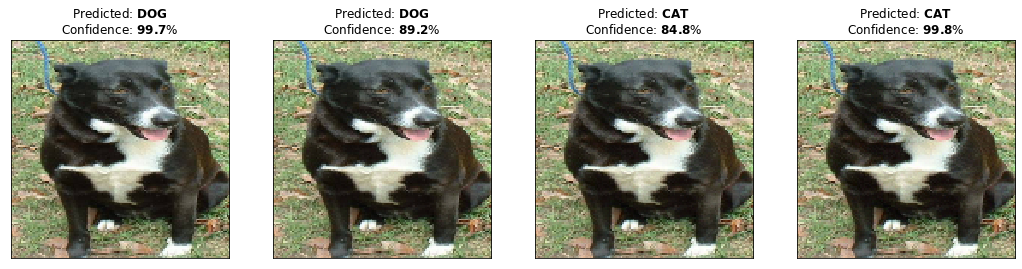

In [29]:
adv_img = adversarial_modify(resz_imgs['./test1/1000.jpg'], to_dog=False)

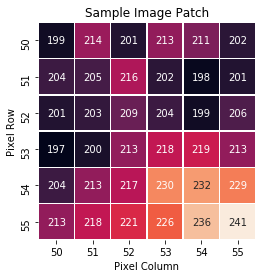

In [9]:
def display_patch(img, title, xyhw=(50,50,6,6), ax=None, cmap=None):
    if ax is None:
        _,ax = plt.subplots(figsize=(4,4))
    x,y,h,w = xyhw
    
    # Take a spatial patch, and just the RED channel (0)
    disp_img = tf.cast(256.0 * img[x:x+h, y:y+h, 0], dtype='int32')
    
    sns.heatmap(disp_img, annot=True, ax=ax, linewidths=0.5, cbar=False, fmt='d', cmap=cmap)
    ax.set_xticklabels([f'{r}' for r in range(x, x+h)])
    ax.set_yticklabels([f'{c}' for c in range(y, y+h)])
    ax.set_xlabel('Pixel Column')
    ax.set_ylabel('Pixel Row')
    #ax.xaxis.set_ticks_position('top')
    #ax.xaxis.set_label_position('top')
    ax.set_title(title)
    ax.set_aspect(1.0)

display_patch(victim_img, 'Sample Image Patch')

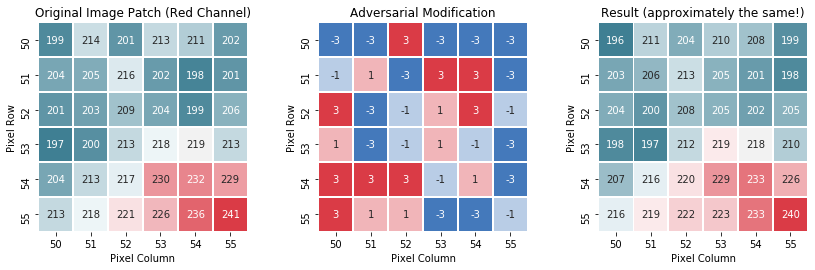

In [11]:
diff_img = victim_img - orig_victim_img
img_cmap = sns.diverging_palette(220, 10,  as_cmap=True)
diff_cmap = sns.diverging_palette(250, 10, as_cmap=True)
fig,axs = plt.subplots(1,3, figsize=(12,6))
display_patch(orig_victim_img, 'Original Image Patch (Red Channel)', cmap=img_cmap, ax=axs[0])
display_patch(diff_img, 'Adversarial Modification', cmap=diff_cmap, ax=axs[1])
display_patch(victim_img, 'Result (approximately the same!)', cmap=img_cmap, ax=axs[2])
plt.tight_layout(3)

In [14]:
# The model uses 
for idx,layer in enumerate(model.layers):
    print(f'Layer {idx:02d}: {layer.name}')

Layer 00: conv1
Layer 01: batch_normalization
Layer 02: max_pooling2d
Layer 03: dropout
Layer 04: conv2
Layer 05: batch_normalization_1
Layer 06: max_pooling2d_1
Layer 07: dropout_1
Layer 08: conv3
Layer 09: batch_normalization_2
Layer 10: max_pooling2d_2
Layer 11: dropout_2
Layer 12: flatten
Layer 13: dense_pre_out
Layer 14: batch_normalization_3
Layer 15: dropout_3
Layer 16: dense_output


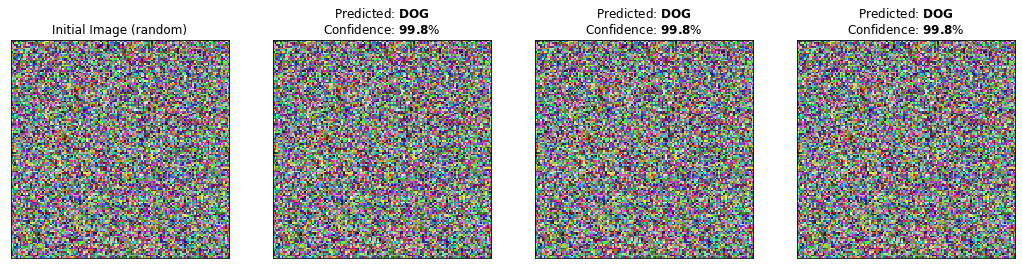

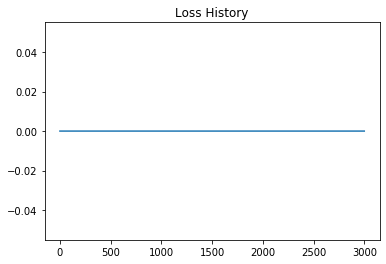

In [18]:
def maximize_model_output(model, layer_name, depth_index):
    """
    We may want to either target both outputs at the same time, or just one
    without regard for what happens to the other.  In the latter case use
    a mask with 0.0 for the value we don't care about.
    """
    partial_model = keras.models.Model(
        inputs=model.inputs,
        outputs=model.get_layer(name=layer_name).output)
    
    dream_img = np.random.uniform(size=(IMAGE_SIZE) + (3,))
    fig, axs = plt.subplots(1,4, figsize=(18,8))
    learning_rate = 0.01

    axs[0].imshow(dream_img)
    axs[0].set_title(get_eval_str(model, dream_img))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title("Initial Image (random)")

    meansq_hist = []
    for i in range(3):

        for j in range(1000):
            # Auto-grad can only track tensors
            tf_dream_img = tf.convert_to_tensor(dream_img, dtype='float32')

            with tf.GradientTape() as tape:
                tape.watch(tf_dream_img)

                # Run the image through the model
                model_output = tf.squeeze(partial_model(tf.expand_dims(tf_dream_img, axis=0)))

                # This is MSE for all values that haven't been masked/ignored
                layer_meansq = tf.reduce_mean(tf.square(model_output[:, :, depth_index]))

            dlayerout_dimg = tape.gradient(layer_meansq, tf_dream_img)

            dream_img -= learning_rate * dlayerout_dimg
            meansq_hist.append(layer_meansq.numpy())
            

        axs[i+1].imshow(dream_img)
        axs[i+1].set_title(f'{get_eval_str(model, dream_img)}')
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])

    fig,ax = plt.subplots()
    ax.plot(meansq_hist)
    ax.set_title('Loss History')

maximize_model_output(model, 'conv3', 101)

## Inspiration taken from this post, but using Tensorflow instead:
https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030

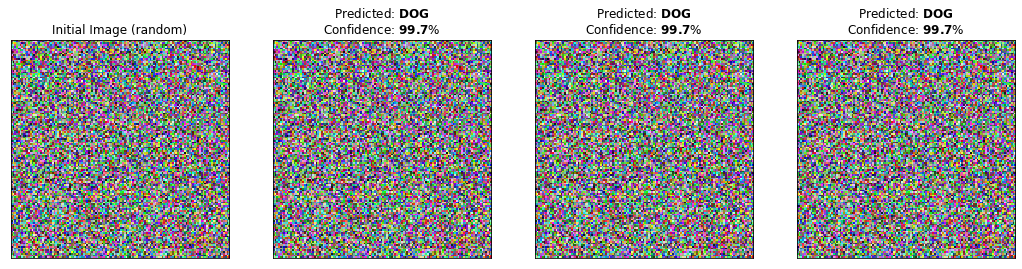

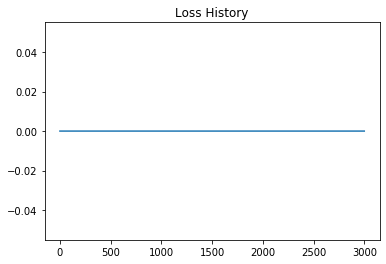

In [317]:
def maximize_model_output(model, start_size=(12,12,3), upsampling_factor=1.2, step_epochs=20)
    """
    We may want to either target both outputs at the same time, or just one
    without regard for what happens to the other.  In the latter case use
    a mask with 0.0 for the value we don't care about.
    """
    output_img = np.random.uniform(0.0, 1.0, size=start_size)
    fig, axs = plt.subplots(1,4, figsize=(18,8))
    learning_rate = 0.01

    axs[0].imshow(dream_img)
    axs[0].set_title(get_eval_str(model, dream_img))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title("Initial Image (random)")

    meansq_hist = []
    while(output_img.shape[0] < IMAGE_SIZE[0]):

        for j in range(1000):
            # Auto-grad can only track tensors
            tf_dream_img = tf.convert_to_tensor(dream_img, dtype='float32')
            tf.image.resize_with_pad()

            with tf.GradientTape() as tape:
                tape.watch(tf_dream_img)

                # Run the image through the model
                model_output = tf.squeeze(partial_model(tf.expand_dims(tf_dream_img, axis=0)))

                # This is MSE for all values that haven't been masked/ignored
                layer_meansq = tf.reduce_mean(tf.square(model_output[:, :, depth_index]))

            dlayerout_dimg = tape.gradient(layer_meansq, tf_dream_img)

            dream_img += learning_rate * dlayerout_dimg
            meansq_hist.append(layer_meansq.numpy())
            

        axs[i+1].imshow(dream_img)
        axs[i+1].set_title(f'{get_eval_str(model, dream_img)}')
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])

    fig,ax = plt.subplots()
    ax.plot(meansq_hist)
    ax.set_title('Loss History')

maximize_model_output(model, 'conv3', 101)